# Compressing Base64 text

Base64 is an encoding scheme that transforms binary data (arbitrary bytes) into text, specifically ASCII characters. Since arbitrary bytes cannot necessarily be rendered as text (something I've talked about [before](https://peterchng.com/blog/2020/01/29/what-every-software-engineer-should-know-about-characters/strings/)), Base64 is typically used to encode these bytes into a "human readable" form. An example of some random bytes encoded using Base64 is:

```
4IkfurCQrFtOQMR7EJVH0Q==
```

Here, "human readable" just means it's able to be rendered as text, since I'm not sure how a normal human would read that.

Base64 works in the following manner:
1. Arrange the bytes in order.
2. Take each group of **three** bytes (24 bits) and divide into **four** sections of 6 bits.
3. Map each 6-bit section to one of 64 characters, since $2^6 = 64$. (Usually the characters are `A-Z, a-z, 0-9, +, /`)
4. Each of the output characters will take up one byte, or 8 bits
5. Some padding might need to be added if the number of input bytes isn't evenly divisible by three. (See the [table of examples here](https://en.wikipedia.org/wiki/Base64#Examples))

Don't worry too much about the exact process. The key point (for the purpose of this article) is that Base64 encoding results in an expansion of the data size by a factor of $4/3$, due to the mapping of 3 input bytes to 4 output bytes.

## Data Compression
Although the Base64 data size is larger, it's not like there is any more _actual_ information in the Base64 data. From an information-theoretic point of view, the information content should be identical to the original.

For example, say I want to represent two values - _True_ and _False_:

- The simplest representation would use 1-bit - **0** for False, and **1** for True.
- If I decided instead to use the strings `"FALSE"` and `"TRUE"`, although this representation would take up more space, there isn't more informational content present compared to the simple 1-bit approach.

The basic idea behind lossless data compression is to reduce input to its simplest (or "pure") representation, thus saving on space. Generally this works by exploiting redundancy or patterns in the input data.

Based on this idea, if we apply some form of compression to the Base64-encoded text then ideally the compressed size should be very close to the original.

## Testing the idea
Let's describe a quick process to test this:

1. Generate some random bytes as the original data. We don't want the original data itself to compress well, because we only want to measure the compressibility after Base64 encoding. Random bytes should not compress well - there is no predictability to them, so they have "high entropy".
2. Base64 encode the random bytes.
3. Compress the Base64-encoded output.
4. Calculate the ratio of compressed size to original size.
5. Do this over a variety of lengths for the original data.

After Base64-encoding and compressing, 1048576 random bytes was 1.009985 larger. (Base64 size was 1.333336 larger)


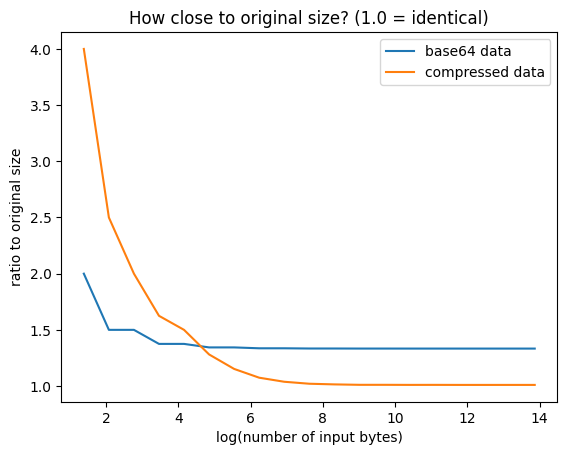

In [28]:
import base64
import os
import zlib # same compression algorithm as gzip (DEFLATE)

import matplotlib.pyplot as plt
import numpy as np

lengths = [2**i for i in range(2, 21)] # byte lengths of 2^2, ... 2^20
b64_ratios = []
c_ratios = []
for l in lengths:
  b = os.urandom(l)         # raw bytes
  b64 = base64.b64encode(b) # bytes-like object, not a string
  c = zlib.compress(b64)    # also bytes

  b64_ratio = len(b64)/len(b) # ratio of base64 to original byte length
  c_ratio = len(c)/len(b)     # ratio of compressed to original byte length

  # Sanity check: Decompress and decode back to original
  if b != base64.b64decode(zlib.decompress(c)):
    raise Exception('Unable to decompress and decode back to original!')

  b64_ratios.append(b64_ratio)
  c_ratios.append(c_ratio)

plt.plot(np.log(lengths), b64_ratios, label='base64 data')
plt.plot(np.log(lengths), c_ratios, label='compressed data')
plt.xlabel('log(number of input bytes)')
plt.ylabel('ratio to original size')
plt.title('How close to original size? (1.0 = identical)')
plt.legend()

print(f'After Base64-encoding and compressing, {lengths[-1]} random bytes was {c_ratios[-1]:.6f} larger. (Base64 size was {b64_ratios[-1]:.6f} larger)')

# Conclusion

Now obviously, this example is ridiculous. The whole point of using Base64 is to convert arbitrary bytes to text, but compression does the inverse - it outputs arbitrary bytes! However, from this very quick and dirty test we can conclude:

1. The Base64 size is $4/3$ times larger than the original size, as expected. It's slightly larger for smaller sizes due to the padding overhead.
2. The compressed size is actually **larger** than the Base64 size for smaller inputs. This is probably due to the overhead of data structures used for compression, such as the dictionary/table generated during the [Huffman coding](https://en.wikipedia.org/wiki/Deflate#Bit_reduction) stage of the DEFLATE compression used by `zlib`.
3. As the input byte size increases, the compressed size tends towards the original size, but the ratio stays slightly above 1. The compression cannot achieve perfect efficiency, and there's also the previously mentioned overhead.

The observation that the compressed size is very close to the original size (point (3)) confirms the intuition that simply expanding the data size with Base64 doesn't add any more information to the message.